In [1]:
#importing all the necessary modules
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2.17.0


In [2]:
#defining some constants
IMAGE_SIZE= 256
BATCH_SIZE = 32

In [3]:
#we are loading the dataset as a 4D Tensor, with shape [batch_size, height, width, channels].
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'leaf_images/',
    shuffle = True,
    batch_size= BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 9648 files belonging to 8 classes.


In [4]:
len(dataset) #number of batches

302

In [5]:
class_names = dataset.class_names #leaf diseases
class_names

['bacterial_blight',
 'cercospora_leaf_blight',
 'downey_mildew',
 'frogeye',
 'healthy',
 'potassium_deficiency',
 'soybean_rust',
 'target_spot']

In [6]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape) #shape of the batch of images, a 4D-Tensor
    print(label_batch.numpy()) #labels for our diseases, we convert the tensor into a numpy array
    print(type(label_batch))

(32, 256, 256, 3)
[4 1 2 4 6 4 3 4 4 7 1 1 3 3 4 4 4 3 3 4 6 6 4 1 3 1 6 6 7 4 6 5]
<class 'tensorflow.python.framework.ops.EagerTensor'>


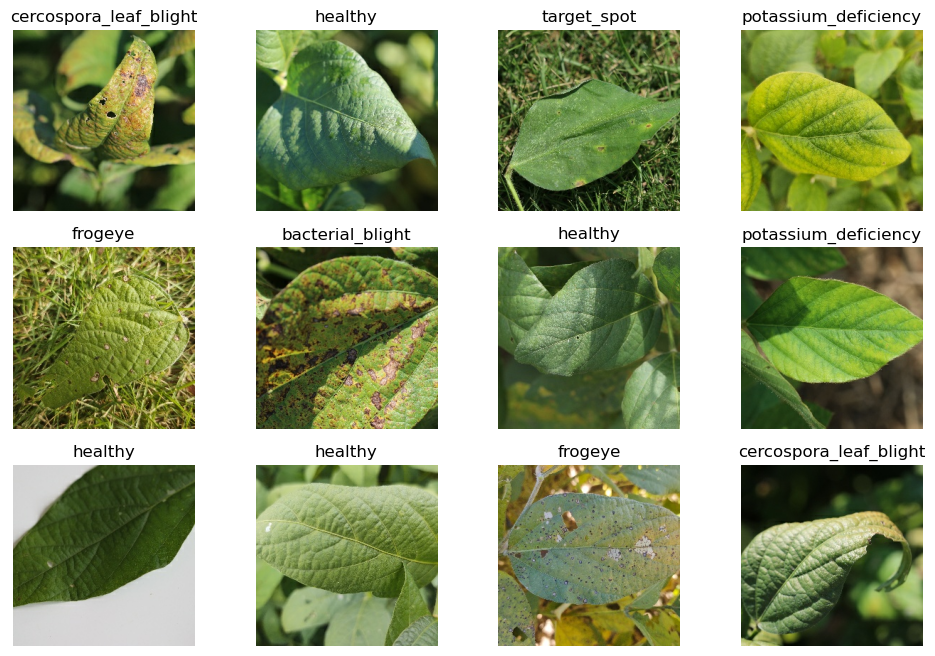

In [7]:
plt.figure(figsize = (12,8))
for batch_of_images, batch_of_labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(batch_of_images[i].numpy().astype('uint8')) #we convert the tensor into a numpy array of type 8 bit unsigned int
        plt.title(class_names[batch_of_labels[i]])
        plt.axis("off")        

### Splitting the dataset
<p>80% Training data <br>
10% Validation Data<br>
10% Test Data</p>

In [10]:
def get_dataset_partitions_tf(ds, train_split = 0.8, valid_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    ds_size = len(ds)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)
    test_size = int(len(ds) * test_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size + valid_size).take(test_size)
    
    return train_ds, valid_ds, test_ds

In [11]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(valid_ds), len(test_ds)

(241, 30, 30)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
#lets define our preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

In [14]:
#lets define our data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3)
])

In [15]:
#import tf_keras
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = len(class_names)
model = tf.keras.Sequential([
    #data augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),

    #rescaling and resizing
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),

    #convolutional layers
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    #dense layers
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [18]:
history = model.fit(train_ds, epochs = 40, batch_size = BATCH_SIZE, verbose = 1, validation_data = valid_ds)

Epoch 1/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 230s 904ms/step - accuracy: 0.2205 - loss: 1.9441 - val_accuracy: 0.3990 - val_loss: 1.6044
Epoch 2/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 205s 846ms/step - accuracy: 0.4089 - loss: 1.6146 - val_accuracy: 0.5063 - val_loss: 1.4316
Epoch 3/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 179s 744ms/step - accuracy: 0.5234 - loss: 1.3411 - val_accuracy: 0.5990 - val_loss: 1.0994
Epoch 4/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 181s 751ms/step - accuracy: 0.6052 - loss: 1.0665 - val_accuracy: 0.6865 - val_loss: 0.8426
Epoch 5/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 182s 754ms/step - accuracy: 0.6750 - loss: 0.9043 - val_accuracy: 0.7312 - val_loss: 0.7663
Epoch 6/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 185s 769ms/step - accuracy: 0.6824 - loss: 0.8491 - val_accuracy: 0.7479 - val_loss: 0.6838
Epoch 7/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 186s 772ms/step - accuracy: 0.7326 - loss: 0.7388 - val_accuracy: 0.7719 - val_loss: 0.5829
Epoch 8/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 186s 771ms/step - accuracy: 0.7521 -

In [19]:
model.save('soy_aug_and_rescaled.keras')

In [20]:
scores = model.evaluate(test_ds)
scores

30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - accuracy: 0.9043 - loss: 0.2681


[0.24243603646755219, 0.9057203531265259]

In [24]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

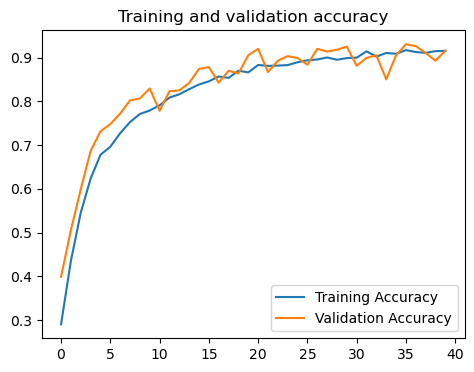

In [25]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(accu, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and validation accuracy")

In [26]:
#import tf_keras
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = len(class_names)
model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])


In [27]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(train_ds, epochs = 50, batch_size = BATCH_SIZE, verbose = 1, validation_data = valid_ds)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 196s 780ms/step - accuracy: 0.1987 - loss: 1.9764 - val_accuracy: 0.4177 - val_loss: 1.5970
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 175s 726ms/step - accuracy: 0.4205 - loss: 1.5910 - val_accuracy: 0.4906 - val_loss: 1.4115
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 174s 721ms/step - accuracy: 0.4939 - loss: 1.3998 - val_accuracy: 0.5875 - val_loss: 1.2251
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 172s 715ms/step - accuracy: 0.5795 - loss: 1.1739 - val_accuracy: 0.6896 - val_loss: 0.9261
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 173s 717ms/step - accuracy: 0.6503 - loss: 0.9886 - val_accuracy: 0.7208 - val_loss: 0.7987
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 174s 720ms/step - accuracy: 0.6915 - loss: 0.8582 - val_accuracy: 0.7635 - val_loss: 0.6550
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 172s 714ms/step - accuracy: 0.7203 - loss: 0.7650 - val_accuracy: 0.7667 - val_loss: 0.6381
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 176s 729ms/step - accuracy: 0.7390 -

In [30]:
model.save('soy_aug_and_rescaled50.keras')

In [31]:
scores = model.evaluate(test_ds)
scores

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9494 - loss: 0.1318


[0.13174524903297424, 0.9470338821411133]